In [2]:
import csv
import chart_studio
import re
import string
# import emot
import collections
import ipywidgets
import contractions
import cufflinks
import nltk.tokenize

import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

# from textblob import TextBlob
#from google.colab import widgets
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

pd.set_option('display.max_colwidth', None)
sid = SentimentIntensityAnalyzer()
# emot_obj = emot.core.emot()
cufflinks.set_config_file(world_readable=True, theme='pearl')
cufflinks.go_offline()
pio.renderers.default = 'colab'

In [3]:
# Reading the CSV to DF & showing DF info
df = pd.read_csv('old_town_road.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265 entries, 0 to 1264
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              1265 non-null   object 
 1   vader_neg       1264 non-null   float64
 2   vader_neu       1264 non-null   float64
 3   vader_pos       1264 non-null   float64
 4   vader_compound  1264 non-null   float64
 5   roberta_neg     1264 non-null   float64
 6   roberta_neu     1264 non-null   float64
 7   roberta_pos     1264 non-null   float64
 8   Text            1264 non-null   object 
dtypes: float64(7), object(2)
memory usage: 89.1+ KB


In [4]:
# Drop duplicates from text column
df = df.drop_duplicates(subset = ['Text'],keep='first')
print(df)

        Id  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0        1      0.000      1.000      0.000          0.0000     0.164698   
1        2      0.000      0.000      1.000          0.4404     0.060793   
2        3      0.000      1.000      0.000          0.0000     0.400678   
3        4      0.000      1.000      0.000          0.0000     0.011754   
4        5      0.000      0.911      0.089          0.4824     0.090882   
...    ...        ...        ...        ...             ...          ...   
1260  1263      0.000      1.000      0.000          0.0000     0.114758   
1261  1264      0.000      0.000      0.000          0.0000     0.259181   
1262  1265      0.000      1.000      0.000          0.0000     0.230317   
1263  1266      0.000      1.000      0.000          0.0000     0.110747   
1264  1267      0.403      0.597      0.000         -0.8442     0.870241   

      roberta_neu  roberta_pos  \
0        0.707790     0.127512   
1        0.329428  

In [5]:
def pre_process(text):
    # Remove links
    text = re.sub('http://\S+|https://\S+', '', str(text))
    text = re.sub('http[s]?://\S+', '', text)
    text = re.sub(r"http\S+", "", text)

    text = re.sub('&amp', 'and', text)
    text = re.sub('&lt', '<', text)
    text = re.sub('&gt', '>', text)

    # Remove new line characters
    text = re.sub('[\r\n]+', ' ', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

    # Remove multiple space characters
    text = re.sub('\s+',' ', text)
    
    return text

In [6]:
# Apply preprocessing to the dataframe / define the column with the comment text
df['processed_text'] = df['Text'].apply(pre_process)

In [7]:
df.sample(n=5)

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Text,processed_text
1264,1267,0.403,0.597,0.000,-0.8442,0.870241,0.120508,0.009250,@пудель sut you ass up than y the hell or you here than my boi,sut you ass up than y the hell or you here than my boi
553,556,0.000,1.000,0.000,0.0000,0.185457,0.485758,0.328785,Omg,Omg
243,244,0.000,0.552,0.448,0.6900,0.321977,0.387969,0.290054,@bluefury looks who talking!? Like u can do better 💀✋,looks who talking!? Like u can do better 💀✋
1102,1105,0.000,0.769,0.231,0.5106,0.027862,0.556982,0.415156,@PC LIRA This is your opinion and you are free to it😊,LIRA This is your opinion and you are free to it😊
722,724,0.000,1.000,0.000,0.0000,0.123404,0.670706,0.205890,Totally,Totally


In [8]:
# Dropping rows with href URL
df = df[df["Text"].str.contains(r'href=\S+') == False]
df = df[df["Text"].str.contains(r'https:\S+') == False]
print(df)

        Id  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0        1      0.000      1.000      0.000          0.0000     0.164698   
1        2      0.000      0.000      1.000          0.4404     0.060793   
2        3      0.000      1.000      0.000          0.0000     0.400678   
3        4      0.000      1.000      0.000          0.0000     0.011754   
4        5      0.000      0.911      0.089          0.4824     0.090882   
...    ...        ...        ...        ...             ...          ...   
1260  1263      0.000      1.000      0.000          0.0000     0.114758   
1261  1264      0.000      0.000      0.000          0.0000     0.259181   
1262  1265      0.000      1.000      0.000          0.0000     0.230317   
1263  1266      0.000      1.000      0.000          0.0000     0.110747   
1264  1267      0.403      0.597      0.000         -0.8442     0.870241   

      roberta_neu  roberta_pos  \
0        0.707790     0.127512   
1        0.329428  

In [9]:
# Dropping rows with non English words
df=df[df.Text.map(lambda x: x.isascii())]
print(df)

        Id  vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0        1      0.000      1.000      0.000          0.0000     0.164698   
1        2      0.000      0.000      1.000          0.4404     0.060793   
5        6      0.000      1.000      0.000          0.0000     0.258892   
7        8      0.272      0.435      0.293          0.0516     0.975138   
8        9      0.000      0.000      1.000          0.4215     0.115661   
...    ...        ...        ...        ...             ...          ...   
1259  1262      0.000      0.000      0.000          0.0000     0.285115   
1260  1263      0.000      1.000      0.000          0.0000     0.114758   
1261  1264      0.000      0.000      0.000          0.0000     0.259181   
1262  1265      0.000      1.000      0.000          0.0000     0.230317   
1263  1266      0.000      1.000      0.000          0.0000     0.110747   

      roberta_neu  roberta_pos  \
0        0.707790     0.127512   
1        0.329428  

In [10]:
#Remove or replacing API symbols with originals each one by one
# df = df.replace('&#39;', " ' ", regex = True)
# df = df.replace('&quot;', " ' ", regex = True)
# df = df.replace('&amp;', ' & ', regex = True)
# df = df.replace('&lt;', " < ", regex = True)
# df = df.replace('<b>', ' ', regex = True)
# df = df.replace('<br>', ' ', regex = True)
# df = df.replace('</b>', ' ', regex = True)
# df = df.replace('@', ' ', regex = True)
# print(df)

In [11]:
# Remove or replacing API symbols with originals chained
# df.Text = df.Text.str.replace("&#39;", " ' ")\
# .str.replace("&amp;", " & ")\
# .str.replace("&lt;", " < ")\
# .str.replace("&quot;", " ' ")\
# .str.replace("<b>", " ")\
# .str.replace("<br>", " ")\
# .str.replace("</b>", " ")\
# .str.replace("@", " ")


In [12]:
df.sample(n=5)

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Text,processed_text
177,178,0.000,0.836,0.164,0.6697,0.001438,0.024293,0.974269,"@Chris Curry In the Brazilian language, this song was translated in a way and for Brazilians, its lyrics are very beautiful if you want, I&#39;ll send them here in the comments","Curry In the Brazilian language, this song was translated in a way and for Brazilians, its lyrics are very beautiful if you want, I&;ll send them here in the comments"
316,317,0.592,0.408,0.000,-0.7003,0.968097,0.028363,0.003541,No one gives a total shit dude,No one gives a total shit dude
273,274,0.000,1.000,0.000,0.0000,0.178622,0.706679,0.114699,Me tooo....,Me tooo....
113,114,0.500,0.286,0.214,-0.4588,0.860432,0.130747,0.008821,Feeling bad for you,Feeling bad for you
275,276,0.000,0.426,0.574,0.4019,0.028212,0.805938,0.165850,@? #andreySantosmelhordomundoumcaraentendedefutebol yes,@? yes


In [13]:
# Display the 20 most present bi-grams
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['processed_text'], 20)


In [14]:
df1 = pd.DataFrame(common_words, columns = ['Comment_Text' , 'count'])
df1.groupby('Comment_Text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar',
    yTitle='Count',
    linecolor='black',
    title='Top 20 bigrams in Comment before removing spams')

# Building a Spam Detection Model

In [15]:
# Import data
df_spam1 = pd.read_csv("yt_spam_data/Youtube01-Channel1.csv")
df_spam2 = pd.read_csv("yt_spam_data/Youtube02-Channel2.csv")
df_spam3 = pd.read_csv("yt_spam_data/Youtube03-Channel3.csv")
df_spam4 = pd.read_csv("yt_spam_data/Youtube04-Channel4.csv")
df_spam5 = pd.read_csv("yt_spam_data/Youtube05-Channel5.csv")
df_spam6 = pd.read_csv("yt_spam_data/Youtube06-Channel6.csv")
# df_spam6 = pd.read_csv("yt_spam_data/5000_yt_comments.csv", encoding= 'unicode_escape')

In [16]:
# Merge data
frames = [df_spam1,df_spam2,df_spam3,df_spam4,df_spam5,df_spam6]
df_merged = pd.concat(frames)
df_merged

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: kobyoshi02",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,"Hey guys check out my new channel and our first vid THIS IS US THE MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment and please subscribe!!!!",1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1
...,...,...,...,...,...
204,205,latrell brown,2013-10-08T18:26:06.234000,Driver side same as the Passenger you just manually went lightly on the drivers side.,0
205,206,OnlineJobs99,2013-10-07T03:35:34.267000,"Now, put your finger there.",0
206,207,WhatUKnow,2013-10-07T02:59:17.497000,What? No hand test on the passenger side?,0
207,208,jameskileymusic,2013-10-06T05:38:47.524000,"go on then, put that finger in there",0


In [17]:
# Assign keys to each dataset
keys = ["Channel1","Channel2","Channel3","Channel4","Channel5","Channel6"]


In [18]:
# Concat keys
df_with_keys = pd.concat(frames,keys=keys)
df_with_keys

COMMENT_ID            AUTHOR  \
Channel1 0    LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU         Julius NM   
         1    LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A       adam riyati   
         2    LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8  Evgeny Murashkin   
         3            z13jhp0bxqncu512g22wvzkasxmvvzjaz04   ElNino Melendez   
         4            z13fwbwp1oujthgqj04chlngpvzmtt3r3dw            GsMega   
...                                                   ...               ...   
Channel6 204                                          205     latrell brown   
         205                                          206      OnlineJobs99   
         206                                          207         WhatUKnow   
         207                                          208   jameskileymusic   
         208                                          209         WhatUKnow   

                                    DATE  \
Channel1 0           2013-11-07T06:20:48   
         1           2013-11-07T12:37:15   
         2           2013-11-08T17:34:21   
         3           2013-11-09T08:28:43   
         4           2013-11-10T16:05:38   
...                                  ...   
Channel6 204  2013-10-08T18:26:06.234000   
         205  2013-10-07T03:35:34.267000   
         206  2013-10-07T02:59:17.497000   
         207  2013-10-06T05:38:47.524000   
         208  2013-10-06T03:24:16.073000   

                                                                                                                                                                             CONTENT  \
Channel1 0                                                                                                                  Huh, anyway check out this you[tube] channel: kobyoshi02   
         1    Hey guys check out my new channel and our first vid THIS IS US THE  MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment  and please subscribe!!!!   
         2                                                                                                                                    just for test I have to say murdev.com   
         3                                                                                                                          me shaking my sexy ass on my channel enjoy ^_^ ﻿   
         4                                                                                                                                   watch?v=vtaRGgvGtWQ   Check this out .﻿   
...                                                                                                                                                                              ...   
Channel6 204                                                                                   Driver side same as the Passenger you just manually went lightly on the drivers side.   
         205                                                                                                                                             Now, put your finger there.   
         206                                                                                                                               What? No hand test on the passenger side?   
         207                                                                                                                                    go on then, put that finger in there   
         208                                                                                              bro saw the carrot getting cut on the passenger side and was like heck nah   

              CLASS  
Channel1 0        1  
         1        1  
         2        1  
         3        1  
         4        1  
...             ...  
Channel6 204      0  
         205      0  
         206      0  
         207      0  
         208      0  

[2163 rows x 5 columns]

In [19]:
# Extract the important columns
df_data = df_with_keys[["CONTENT","CLASS"]]

In [20]:
# Specify input (x) and output (y) variables
df_x = df_data['CONTENT']
df_y = df_data['CLASS']

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
# Feature extraction from input variable
corpus = df_x
cv = CountVectorizer()
X = cv.fit_transform(corpus)

In [23]:
# Convert the numeric values into an array
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [25]:
# Split 70% of data for training the model, 30% to test the model
X_train, X_test, y_train, y_test = train_test_split(X, df_y, test_size=0.30, random_state=42)

In [26]:
# Initialize MultinomialNB
clf = MultinomialNB()

In [27]:
# Fit the model
clf.fit(X_train,y_train)

MultinomialNB()

In [28]:
# Calculate the accuracy score of the model
print("Accuracy of Model",clf.score(X_test,y_test)*100,"%")

Accuracy of Model 91.52542372881356 %


In [29]:
# Classify YT comments
clf.predict(X_test)

array([0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,

In [30]:
# Test the model - spam(1) or non-spam(0)
comment = ["i think you will like my new song"]
vect = cv.transform(comment).toarray()
clf.predict(vect)

array([1])

In [31]:
comment1 = ["baited gomunkul 6 style"]
vect = cv.transform(comment1).toarray()
clf.predict(vect)

array([0])

In [38]:
not_df = pd.read_json("small_channels_comments.json")
not_df = not_df["comments"][0]
not_df = pd.DataFrame(not_df,columns=["Text"])
not_df.head()

,Text
0,Wheel Cleaner is In production and pre-order is officially open please visit auto-fanatic.com
1,8 months? Is that all.
2,impressed very effective
3,"No matter what, you have to use brushes and agitate ......"
4,"Good video BUT, why don't you ""articulate"" that wand from a ""below angle"" in order to hit the spokes at 11 to 2 O'clock which remained virtually un-touched by both the pre-solution AND the foam??? Drives me a bit crazy to see that, LOL!"


In [39]:
all_comments = (not_df["Text"])

In [40]:
all_vect = cv.transform(all_comments).toarray()
all_vect

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [41]:
all_pred = clf.predict(all_vect)
all_pred


array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,

In [42]:
vect_list = all_pred.tolist()
vect_list

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,


In [43]:
df_vect = pd.DataFrame({'results': vect_list})
df_vect.sample(n=10)

,results
227,0
15,0
337,1
196,0
82,1
6,0
272,0
112,0
88,0
175,1


In [44]:
inner_joined = pd.concat([not_df, df_vect], axis="columns", join="inner")


In [45]:
inner_joined[inner_joined["results"]==1]

,Text,results
0,Wheel Cleaner is In production and pre-order is officially open please visit auto-fanatic.com,1
7,Hope to see a cleaner eventually that can be used without a foam machine. Not buying a foam archive just want to be able to soeay my wheels with the cleaner from a spray bottle type. To expensive to buy a foamer and the solution.,1
11,Will it be safe on a painted wheels? Thank you very much.,1
12,All alloy wheels are rough on the inside,1
17,"It’s almost not worth doing, it’ll be right back immediately.",1
...,...,...
550,"As always a great demo, anxiously waiting for the package to be purchase able. Put me on the pre order list, please!",1
553,Looking forward to trying this product!,1
554,I have the 2017 mustang gt with the performance pack rims and they are just a pain to clean. The color and spokes make it so hard to remove the brake dust. All the products I’ve tried either don’t clean or stain them only making it harder to clean. I’m impressed by this product and will definitely be buying it. 👌,1
555,Like the new logo style on the intro,1


In [46]:
inner_joined.shape

(557, 2)

In [47]:
inner_joined.sample(n=5)

,Text,results
246,"So why do you need to clean the inside of the wheels, especially if you can't see it?",1
9,Stove cleaner is good For that stuff it cleans better than purple power,0
427,once you clean the wheel.. is there anything to keep it from building brake dust and crap from trashing the wheel again... or is washing the only way to keep the wheels clean,0
266,Can it be used on car paint as a decontamination process ?\n\nThanks,1
479,But who is looking at that dust?,0


In [48]:
inner_joined.shape

(557, 2)

In [49]:
spam_dropped = inner_joined[inner_joined.results != 1]

In [50]:
spam_dropped.shape

(336, 2)

In [ ]:
# to_drop = ["i think you will like my new song", "Repent to Allah in Islam because","HOLY BIBLE", "school ganstas on Gomunkul 6", "youth on Gomunkul 6", \
#    "TRYNA SOUND LIKE GOMUNKUL 6", "normal people listening Gomunkul 6", "baited gomunkul 6 style", "uploaded a song to my channel if you want", "MONEYYY"]


In [ ]:
# df = df[~df['Text'].str.contains('|'.join(to_drop))]

In [ ]:
def expand_contractions(text):
  try:
    return contractions.fix(text)
  except:
    return text

In [ ]:

spam_dropped['expanded_text'] = spam_dropped['Text'].apply(expand_contractions)
spam_dropped['processed_text'] = spam_dropped['expanded_text'].apply(pre_process)


In [ ]:
spam_dropped.sample(n=5)

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Text,processed_text,expanded_text
510,513,0.000,0.706,0.294,0.3612,0.161048,0.787230,0.051723,Like how your mother is with you,Like how your mother is with you,Like how your mother is with you
275,276,0.000,0.426,0.574,0.4019,0.028212,0.805938,0.165850,@? #andreySantosmelhordomundoumcaraentendedefutebol yes,@? yes,@? #andreySantosmelhordomundoumcaraentendedefutebol yes
624,627,0.000,0.476,0.524,0.2960,0.012886,0.396496,0.590618,@L0LZZYT69 hahahah yeah,hahahah yeah,@L0LZZYT69 hahahah yeah
1218,1221,0.000,1.000,0.000,0.0000,0.120608,0.812958,0.066434,@juicesipp normal?,normal?,@juicesipp normal?
601,604,0.188,0.426,0.386,0.5160,0.442942,0.495947,0.061111,@NegroSlayer6000 i guess i just missed that memo XD,i guess i just missed that memo XD,@NegroSlayer6000 i guess i just missed that memo XD


In [ ]:
# Save DF into CSV file
# df.to_csv("old_town_road_clean.csv")

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(spam_dropped['processed_text'], 21)
common_words = common_words[1:]

for word, freq in common_words:
    print(word, freq)


years old 3
old town 3
love song 3
yes does 2
believing religion 2
right right 2
horse old 2
town road 2
5th grade 2
don listen 2
inch nails 2
luvs kuromii 2
just didn 2
bro kidding 2
que comprei 2
comprei hoje 2
chris jericho 2
did love 2
old tau 1
tau roud 1


In [ ]:
df4 = pd.DataFrame(common_words, columns = ['CommentText' , 'count'])
df4.groupby('CommentText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in Comments after removing spams')

In [ ]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(spam_dropped['processed_text'], 20)

for word, freq in common_words:
    print(word, freq)



horse old town 2
old town road 2
que comprei hoje 2
did love song 2
old tau roud 1
yes does song 1
does song sucks 1
yo mom gay 1
things better stronger 1
better stronger kid 1
stronger kid hang 1
just heard yesterday 1
heard yesterday god 1
yesterday god dame 1
hahahaha smooth criminal 1
oh said fricking 1
said fricking doesent 1
fricking doesent change 1
doesent change fucking 1
change fucking fakt 1


In [ ]:
df6 = pd.DataFrame(common_words, columns = ['CommentText' , 'count'])
df6.groupby('CommentText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar',
    yTitle='Count',
    linecolor='black',
    title='The 20 most frequent tri-grams in the dataset (without stopwords and spams)')

In [ ]:
# Initialize Lemmatize
wordnet_lem = WordNetLemmatizer()

# Lemmatize processed text and join everything in a list
spam_dropped['text_lem'] = spam_dropped['processed_text'].apply(wordnet_lem.lemmatize)
all_words_lem = ' '.join([word for word in df['text_lem']])

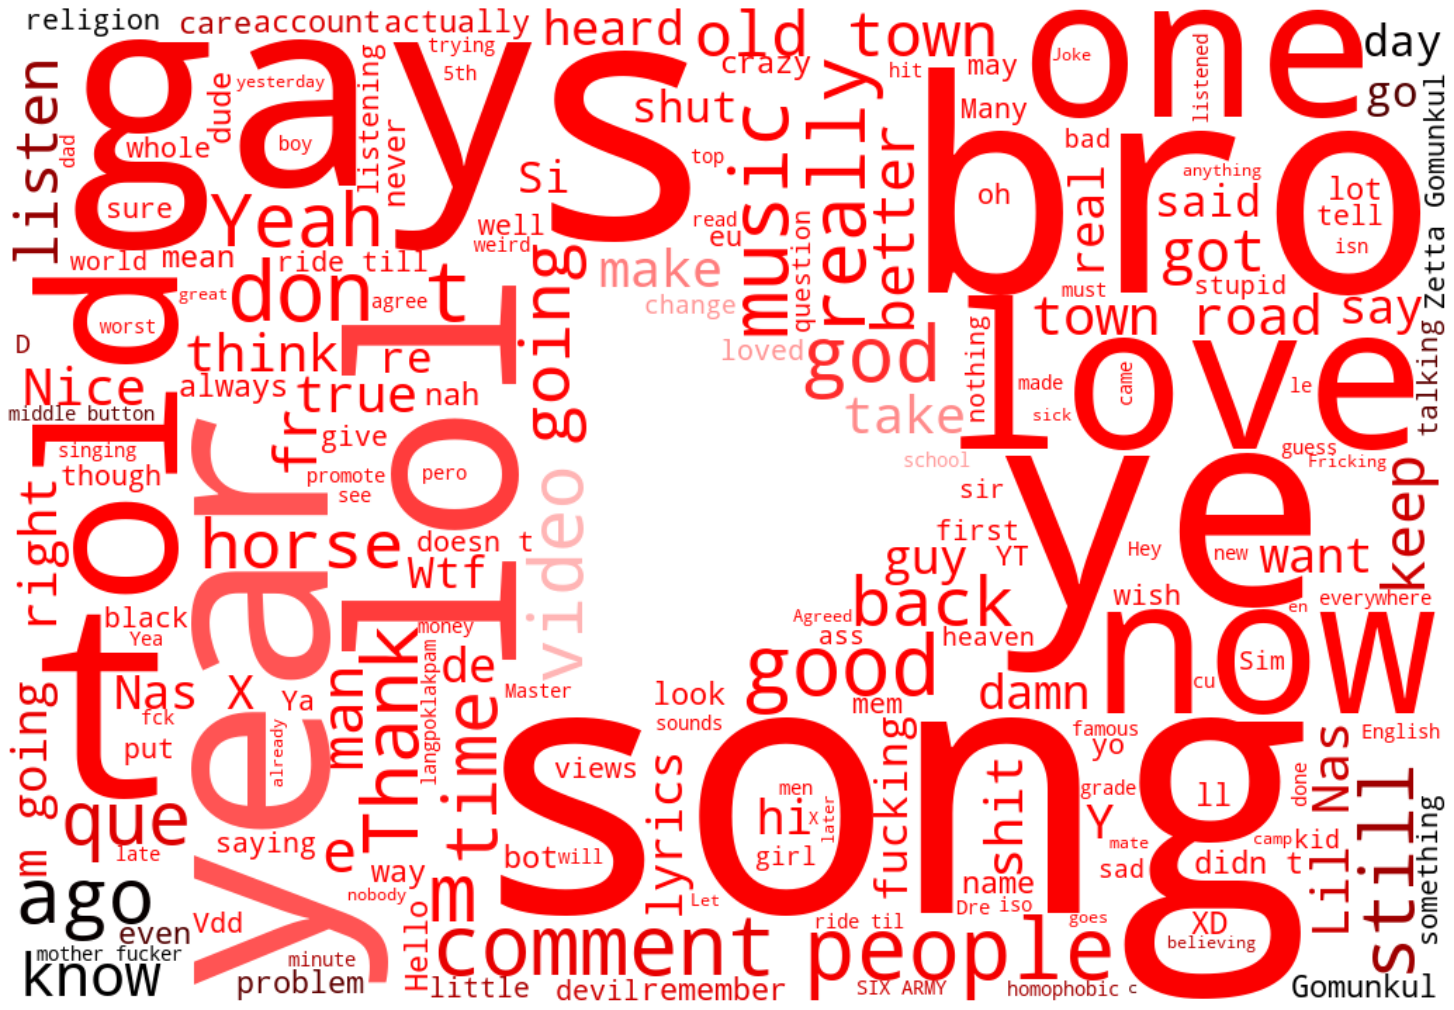

In [ ]:
# Generate a word cloud image
mask = np.array(Image.open("youtube.png"))
stopwords = set(STOPWORDS)

wordcloud_twitter = WordCloud(height=708,
                              width=1024,
                              background_color="white",
                              mode="RGBA",
                              stopwords=stopwords,
                              mask=mask).generate(all_words_lem)

# Create coloring from the image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud_twitter.recolor(color_func=image_colors), interpolation="bilinear")

# Store visualization to file
plt.savefig("yt_logo_unigram.png", format="png")

plt.show()

In [ ]:
word_to_remove = "lil nas"
new_string = ""

for word in spam_dropped['processed_text']:
    if word != word_to_remove:
        new_string += word + " "

new_string = new_string.strip()

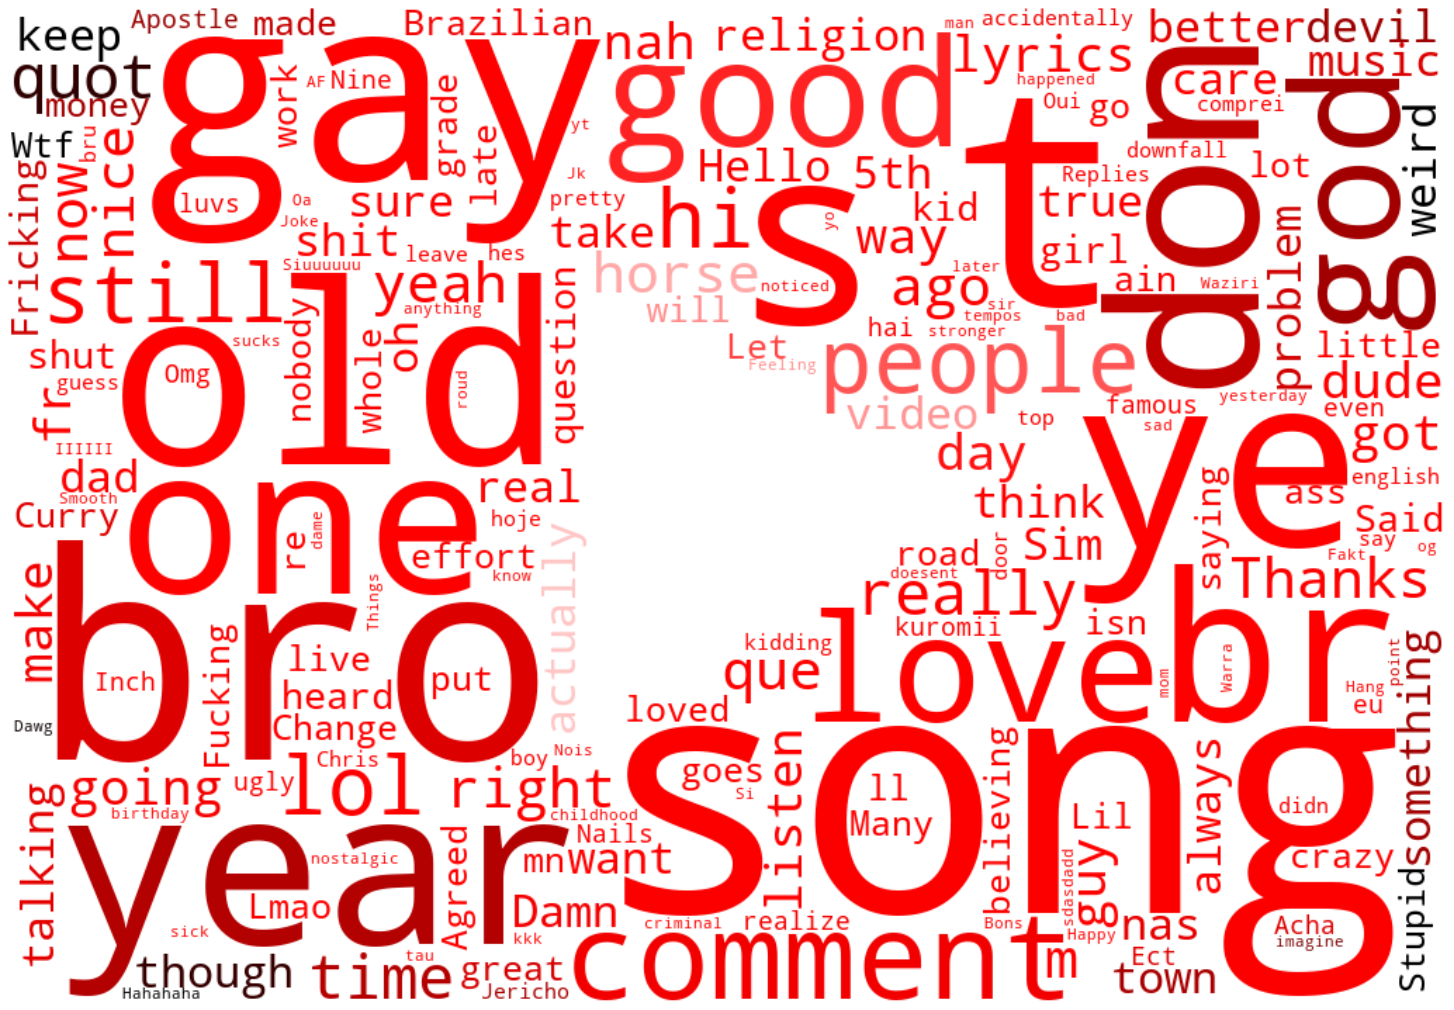

In [ ]:
# Generate a word cloud image
mask = np.array(Image.open("youtube.png"))
stopwords = set(STOPWORDS)

wordcloud_twitter = WordCloud(height=2000,
                              width=2000,
                              background_color="white",
                              mode="RGBA",
                              stopwords=stopwords,
                              collocations = False,
                              mask=mask).generate(new_string)

# Create coloring from the image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud_twitter.recolor(color_func=image_colors), interpolation="bilinear")

# Store visualization to file
# plt.savefig("twitter_logo_mentions_wo_lilnas.png", format="png")

plt.show()